In [2]:
# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, 
confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, classification_report)

from sklearn.model_selection import cross_val_score, GridSearchCV
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from sklearn.metrics import make_scorer
from sklearn.utils import resample

 
import random
random.seed(100)

import time
import pyodbc
print(pyodbc.drivers())
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
 
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# mlflow
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [3]:
df  = pd.read_pickle('../data/interim/processed_data.pkl')
df.shape

(121799, 35)

In [4]:
data = df.copy(deep=True)
data.head()

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,ID,Default
0,20250.0,1.0,0.0,1.0,1.0,0.0,15282.000000,1826.550049,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.00,7833.0,21.0,1,0,1,2.0,2.0,3.0,10,Yes,Yes,0.215068,0.511202,755.0,1.0,12138936,0
1,13500.0,0.0,0.0,1.0,1.0,0.0,60415.199219,3097.800049,Alone,Retired,Secondary,M,Male,CL,Home,0.009175,22493.0,12020.75,12617.0,5280.0,1,0,1,2.0,2.0,4.0,15,Yes,Yes,0.657508,0.549596,1687.0,4.0,12215264,0
2,12150.0,0.0,0.0,0.0,1.0,0.0,16320.150391,1294.650024,Alone,Retired,Secondary,W,Male,CL,Home,0.016612,20507.0,12020.75,2834.0,4053.0,1,0,0,1.0,2.0,3.0,9,Yes,Yes,0.063343,0.113294,533.0,5.0,12130547,0
3,15750.0,0.0,1.0,1.0,1.0,0.0,45000.000000,3007.350098,Alone,Service,Secondary,S,Female,CL,Home,0.008866,14536.0,3465.00,5871.0,2594.0,1,1,0,1.0,2.0,2.0,17,Yes,Yes,0.129861,0.590233,340.0,2.0,12106559,0
4,9000.0,0.0,0.0,0.0,0.0,0.0,22500.000000,2191.949951,Alone,Service,Secondary,S,Male,CL,Home,0.020892,15734.0,2504.00,6019.0,1191.0,1,0,0,1.0,2.0,2.0,11,Yes,Yes,0.418630,0.595456,2458.0,2.0,12186490,0


In [5]:
data['ID'] = data['ID'].astype('int')

In [6]:
imp_cols = [ 'ID','Client_Income', 'Car_Owned', 'Active_Loan', 'House_Own',
        'Credit_Amount', 'Loan_Annuity', 
       'Client_Income_Type', 'Client_Education', 
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Age_Days', 'Employed_Days', 'ID_Days', 'Cleint_City_Rating',
       'Client_Permanent_Match_Tag', 
       'Score_Source_2', 'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default']

In [7]:
imp_data = data[imp_cols]
imp_data.shape

(121799, 22)

### Undersampling

In [8]:
# Step 1: Separate majority and minority classes
data_majority = imp_data[imp_data['Default'] == '0']
data_minority = imp_data[imp_data['Default'] == '1']

# Step 2: Define the percentage for undersampling (e.g., 40%)
undersample_percent = 0.4  # Retain 40% of majority class

# Calculate the number of records to keep from the majority class
n_majority_to_keep = int(len(data_majority) * undersample_percent)
print(n_majority_to_keep)

44783


In [9]:

# Step 3: Downsample the majority class
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sample without replacement
    n_samples=n_majority_to_keep,  # Retain only the specified percentage
    random_state=42  # For reproducibility
)

# Step 4: Combine the downsampled majority class with the minority class
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Step 5: Shuffle the combined dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Check the new class distribution
print("Class distribution after percentage-based undersampling:\n", data_balanced['Default'].value_counts())

Class distribution after percentage-based undersampling:
 Default
0    44783
1     9841
Name: count, dtype: int64


In [10]:
# Separate features and target
X = data_balanced.drop(columns=['Default'])
y = data_balanced['Default']

In [11]:
# Step 2: Encode categorical variables using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)  # Convert categorical features to numerical

# Step 3: Train-Test Split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train shape: (43699, 30)
X_test shape: (10925, 30)
y_train: (43699,)
y_test: (10925,)


In [12]:
# Step 3: Store 'ID' separately for mapping after predictions
ID_train = X_train['ID']  # Store train IDs
ID_test = X_test['ID']  # Store test IDs

# Step 4: Drop 'ID' from feature set before transformations & model training
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

In [13]:
# Step 4: Standardize numerical features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Step 6: Train Logistic Regression Model
random.seed(42)

model = LogisticRegression(penalty='l1', C=0.01, max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)

# model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Make Predictions
y_pred = model.predict(X_test_scaled)
# y_pred = y_pred.astype(int)

In [15]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
# Step 8: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


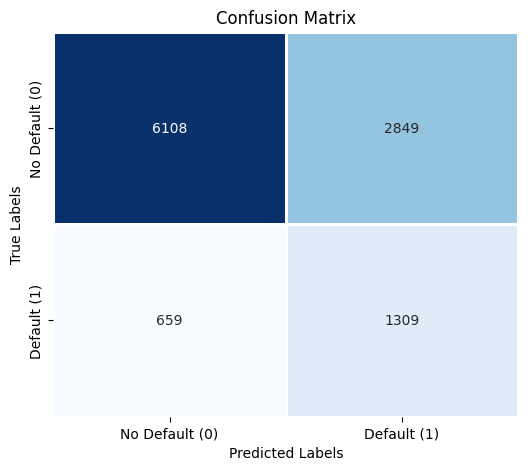

In [16]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False, xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])

# Formatting
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Step 9: Store Predictions with 'ID' for Mapping
results_df = pd.DataFrame({'ID': ID_test.values, 'Actual': y_test.values, 'Predicted': y_pred})

# Display Results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Model Accuracy: 0.6789

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.78      8957
           1       0.31      0.67      0.43      1968

    accuracy                           0.68     10925
   macro avg       0.61      0.67      0.60     10925
weighted avg       0.80      0.68      0.71     10925


Confusion Matrix:
 [[6108 2849]
 [ 659 1309]]


In [18]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Compute Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Using probability scores

# Print Evaluation Metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Precision: 0.3148
Recall: 0.6651
F1 Score: 0.4274
ROC-AUC Score: 0.7283


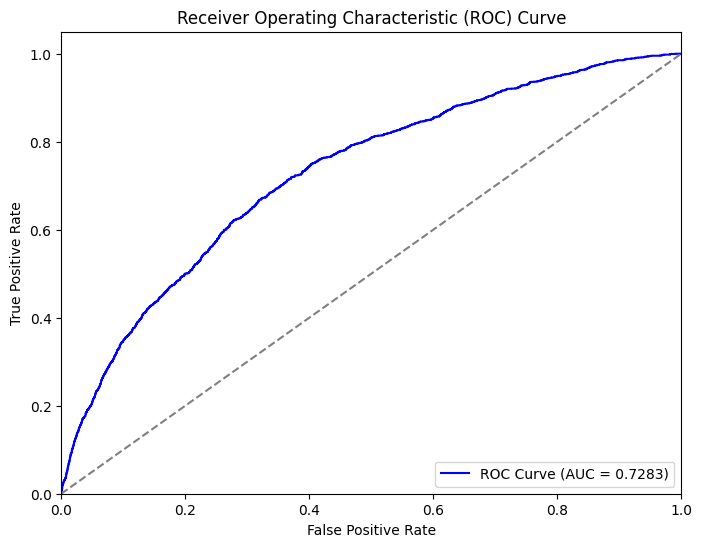

In [19]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])  # Absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

In [21]:
feature_importance

,Feature,Importance
11,Score_Source_3,0.476277
10,Score_Source_2,0.389081
7,Employed_Days,0.210219
20,Client_Education_Secondary,0.191994
21,Client_Gender_Male,0.171193
1,Car_Owned,0.109378
22,Loan_Contract_Type_RL,0.091175
9,Cleint_City_Rating,0.088180
16,Client_Income_Type_Retired,0.077848
5,Loan_Annuity,0.064731


In [23]:
import pickle

# Example: Assume `model` is your trained model
with open("../model/model.pkl", "wb") as file:
    pickle.dump(model, file)

print("✅ Model saved as 'model.pkl'")


✅ Model saved as 'model.pkl'


In [24]:
imp_data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Active_Loan', 'House_Own',
       'Credit_Amount', 'Loan_Annuity', 'Client_Income_Type',
       'Client_Education', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Age_Days', 'Employed_Days', 'ID_Days',
       'Cleint_City_Rating', 'Client_Permanent_Match_Tag', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

In [25]:
imp_data.dtypes

ID                              int32
Client_Income                 float64
Car_Owned                     float64
Active_Loan                   float64
House_Own                     float64
Credit_Amount                 float64
Loan_Annuity                  float64
Client_Income_Type             object
Client_Education               object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Age_Days                      float64
Employed_Days                 float64
ID_Days                       float64
Cleint_City_Rating            float64
Client_Permanent_Match_Tag     object
Score_Source_2                float64
Score_Source_3                float64
Phone_Change                  float64
Credit_Bureau                 float64
Default                        object
dtype: object

In [26]:
X_train.columns

Index(['Client_Income', 'Car_Owned', 'Active_Loan', 'House_Own',
       'Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Employed_Days', 'ID_Days',
       'Cleint_City_Rating', 'Score_Source_2', 'Score_Source_3',
       'Phone_Change', 'Credit_Bureau', 'Client_Income_Type_Govt Job',
       'Client_Income_Type_Other', 'Client_Income_Type_Retired',
       'Client_Income_Type_Service', 'Client_Education_Graduation dropout',
       'Client_Education_Junior secondary', 'Client_Education_Secondary',
       'Client_Gender_Male', 'Loan_Contract_Type_RL',
       'Client_Housing_Type_Home', 'Client_Housing_Type_Municipal',
       'Client_Housing_Type_Office', 'Client_Housing_Type_Rental',
       'Client_Housing_Type_Shared', 'Client_Permanent_Match_Tag_Yes'],
      dtype='object')